In [1]:
# Librerías estándar y manipulación de archivos
import os
import joblib
import json
import pickle

# Manipulación de datos y operaciones básicas
import numpy as np
import pandas as pd

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation

# Preprocesamiento de datos
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Reducción de dimensionalidad
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Modelos de Machine Learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Selección y validación de modelos
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, GridSearchCV, StratifiedKFold

# Técnicas de balanceo de clases
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Métricas de evaluación
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc

# Configuraciones adicionales
import warnings

# Se ignoran los warnings en el notebook
warnings.filterwarnings('ignore')

#Se importan las librerias necesarias para el uso de pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Se define el dispositivo a utilizar
print(torch.__version__)
print("CUDA disponible:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Número de GPU disponibles:", torch.cuda.device_count())
    print("Nombre de la GPU 0:", torch.cuda.get_device_name(0))
    print("Dispositivo actual:", torch.cuda.current_device())


2.3.0
CUDA disponible: True
Número de GPU disponibles: 1
Nombre de la GPU 0: NVIDIA GeForce RTX 3090
Dispositivo actual: 0


In [2]:
# Se define la funcion para graficar la perdida por epoca
def graficar_progreso(losses, inicio_folds, dataset_name, grado=3):
    plt.figure(figsize=(20, 10))
    # Gráfico original
    plt.plot(range(1, len(losses) + 1), losses, marker='o', linestyle='-', color='blue', label='Pérdida Real')

     # Marcar y anotar el inicio de cada fold
    for i, inicio in enumerate(inicio_folds):
        plt.axvline(x=inicio, color='black', linestyle='--', lw=1)
        plt.text(inicio, max(losses)*0.95, f'Inicio Fold {i+1}', rotation=90, color='black', fontsize=12, fontweight='bold')

    # Ajustando la curva de tendencia
    z = np.polyfit(range(1, len(losses) + 1), losses, grado)  # Ajuste polinomial
    p = np.poly1d(z)  # Creación de un polinomio
    plt.plot(range(1, len(losses) + 1), p(range(1, len(losses) + 1)), "r--", label='Curva de Tendencia')  # Curva de tendencia en rojo

    # Configuración del gráfico
    plt.title(f'Pérdida por Época a través de los Folds, Dataset: {dataset_name}')
    plt.xlabel('Época Total')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.grid(True)
    plt.show()


In [3]:
def evaluar_modelo_pytorch(model, X_train_tensor, y_train, X_test_tensor, y_test, dataset_name):
    # Evaluación con datos de entrenamiento
    y_pred = model(X_train_tensor).detach().cpu().numpy()
    y_pred_bin = (y_pred > 0.5).astype(int)

    # Cálculo de métricas para datos de entrenamiento
    accuracy = accuracy_score(y_train, y_pred_bin)
    precision = precision_score(y_train, y_pred_bin)
    recall = recall_score(y_train, y_pred_bin)
    f1 = f1_score(y_train, y_pred_bin)

    # Visualización de métricas y gráficos para datos de entrenamiento
    print('\033[1m' + '.' * len("Resultados datos de entrenamiento:") + '\n' + "Resultados datos de entrenamiento:" + '\033[0m')
    print(f"Accuracy (Datos de Train): {accuracy}")
    print(f"Precision (Datos de Train): {precision}")
    print(f"Recall (Datos de Train): {recall}")
    print(f"F1 Score (Datos de Train): {f1}")

    # Gráficos para datos de entrenamiento
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'Resultados de Train para el Dataset: - {dataset_name}', fontsize=16, fontweight='bold', y=1.05)
    conf_matrix = confusion_matrix(y_train, y_pred_bin)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['Asiste', 'No-show'], yticklabels=['Asiste', 'No-show'])
    axes[0].set_title('Matriz de Confusión (Datos de Train)')
    axes[0].set_xlabel('Predicho')
    axes[0].set_ylabel('Real')
    print(conf_matrix)

    fpr, tpr, thresholds = roc_curve(y_train, y_pred)
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_title('Curva ROC (Datos de Train)')
    axes[1].set_xlabel('Tasa de Falsos Positivos')
    axes[1].set_ylabel('Tasa de Verdaderos Positivos')
    axes[1].legend(loc="lower right")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Evaluación con datos de prueba
    y_pred_test = model(X_test_tensor).detach().cpu().numpy()
    y_pred_test_bin = (y_pred_test > 0.5).astype(int)

    # Cálculo de métricas para datos de prueba
    accuracy_test = accuracy_score(y_test, y_pred_test_bin)
    precision_test = precision_score(y_test, y_pred_test_bin)
    recall_test = recall_score(y_test, y_pred_test_bin)
    f1_test = f1_score(y_test, y_pred_test_bin)

    # Visualización de métricas y gráficos para datos de prueba
    print('\033[1m' + '.' * len("Resultados datos de test:") + '\n' + "Resultados datos de test:" + '\033[0m')
    print(f"Accuracy (Datos de Test): {accuracy_test}")
    print(f"Precision (Datos de Test): {precision_test}")
    print(f"Recall (Datos de Test): {recall_test}")
    print(f"F1 Score (Datos de Test): {f1_test}")

    # Gráficos para datos de prueba
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'Resultados de Test para el Dataset: - {dataset_name}', fontsize=16, fontweight='bold', y=1.05)
    conf_matrix_test = confusion_matrix(y_test, y_pred_test_bin)
    sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Reds', ax=axes[0],
                xticklabels=['Asiste', 'No-show'], yticklabels=['Asiste', 'No-show'])
    axes[0].set_title('Matriz de Confusión (Datos de Test)')
    axes[0].set_xlabel('Predicho')
    axes[0].set_ylabel('Real')
    print(conf_matrix_test)

    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test)
    roc_auc_test = auc(fpr_test, tpr_test)
    axes[1].plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'AUC = {roc_auc_test:.2f}')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_title('Curva ROC (Datos de Test)')
    axes[1].set_xlabel('Tasa de Falsos Positivos')
    axes[1].set_ylabel('Tasa de Verdaderos Positivos')
    axes[1].legend(loc="lower right")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [4]:
def execute_model_pytorch(X_train, y_train, X_test, y_test, device, dataset_name):
    class NeuralNet(nn.Module):
        def __init__(self, input_size):
            super(NeuralNet, self).__init__()
            self.layer1 = nn.Linear(input_size, 64)
            self.bn1 = nn.BatchNorm1d(64)
            self.relu1 = nn.ReLU()

            self.layer2 = nn.Linear(64, 32)
            self.bn2 = nn.BatchNorm1d(32)
            self.relu2 = nn.ReLU()
            self.dropout1 = nn.Dropout(0.3)

            self.output_layer = nn.Linear(32, 1)
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            out = self.bn1(self.layer1(x))
            out = self.relu1(out)

            out = self.bn2(self.layer2(out))
            out = self.relu2(out)
            out = self.dropout1(out)

            out = self.output_layer(out)
            out = self.sigmoid(out)
            return out

    model = NeuralNet(X_train.shape[1]).to(device)

    model_dir = 'models'
    os.makedirs(model_dir, exist_ok=True)
    model_filename = os.path.join(model_dir, f'modelo_pytorch_{dataset_name}.pth')

    if os.path.exists(model_filename):
        model.load_state_dict(torch.load(model_filename))
        print("Modelo cargado exitosamente.")

        X_test_tensor = torch.tensor(X_test).float().to(device)
        X_train_fold_tensor = torch.tensor(X_train).float().to(device)
        y_train_fold = y_train
        evaluar_modelo_pytorch(model, X_train_fold_tensor, y_train_fold, X_test_tensor, y_test, dataset_name)
        return

    skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    num_epochs = 10
    patience = 10  # Número de épocas a esperar antes de detener el entrenamiento si no hay mejora
    fold_results = []
    losses = []
    inicio_folds = [1]
    epoca_actual = 0

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    for fold, (train_index, test_index) in enumerate(skfolds.split(X_train, y_train)):
        print(f'Comenzando el fold {fold+1}')

        X_train_fold = X_train[train_index]
        y_train_fold = y_train[train_index]
        X_valid_fold = X_train[test_index]
        y_valid_fold = y_train[test_index]

        X_train_fold_tensor = torch.tensor(X_train_fold).float().to(device)
        y_train_fold_tensor = torch.tensor(y_train_fold.to_numpy()[:, None]).float().to(device)
        X_valid_fold_tensor = torch.tensor(X_valid_fold).float().to(device)
        y_valid_fold_tensor = torch.tensor(y_valid_fold.to_numpy()[:, None]).float().to(device)

        train_loader = DataLoader(TensorDataset(X_train_fold_tensor, y_train_fold_tensor), batch_size=64, shuffle=True)
        valid_loader = DataLoader(TensorDataset(X_valid_fold_tensor, y_valid_fold_tensor), batch_size=64)

        epoch_losses = []
        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(num_epochs):
            model.train()
            train_losses = []
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())

            model.eval()
            val_losses = []
            with torch.no_grad():
                for inputs, targets in valid_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_losses.append(loss.item())

            epoch_train_loss = torch.tensor(train_losses).mean().item()
            epoch_val_loss = torch.tensor(val_losses).mean().item()
            epoch_losses.append((epoch_train_loss, epoch_val_loss))
            losses.append(epoch_val_loss)
            print(f'Fold {fold+1}, Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

            # Step the scheduler
            scheduler.step(epoch_val_loss)

            # Early Stopping
            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss
                patience_counter = 0
                # Guardar el mejor modelo
                torch.save(model.state_dict(), model_filename)
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f'Early stopping en la época {epoch+1}')
                break

        fold_results.append({
            'fold': fold+1,
            'epoch_losses': epoch_losses,
        })
        if fold < skfolds.n_splits - 1:
            epoca_actual += num_epochs
            inicio_folds.append(epoca_actual + 1)

    # Cargar el mejor modelo guardado
    model.load_state_dict(torch.load(model_filename))
    print(f"Modelo guardado en {model_filename}")

    graficar_progreso(losses, inicio_folds, dataset_name, grado=3)

    X_test_tensor = torch.tensor(X_test).float().to(device)

    X_train_fold_tensor = torch.tensor(X_train).float().to(device)
    y_train_fold = y_train

    evaluar_modelo_pytorch(model, X_train_fold_tensor, y_train_fold, X_test_tensor, y_test, dataset_name)



Ejecutando modelo para el dataset: P1-ALL-ADASYN

Comenzando el fold 1
Fold 1, Epoch 1, Train Loss: 0.6729, Val Loss: 0.6466
Fold 1, Epoch 2, Train Loss: 0.6463, Val Loss: 0.6293
Fold 1, Epoch 3, Train Loss: 0.6340, Val Loss: 0.6183
Fold 1, Epoch 4, Train Loss: 0.6263, Val Loss: 0.6130
Fold 1, Epoch 5, Train Loss: 0.6204, Val Loss: 0.6073
Fold 1, Epoch 6, Train Loss: 0.6161, Val Loss: 0.6029
Fold 1, Epoch 7, Train Loss: 0.6128, Val Loss: 0.5995
Fold 1, Epoch 8, Train Loss: 0.6108, Val Loss: 0.5977
Fold 1, Epoch 9, Train Loss: 0.6068, Val Loss: 0.5971
Fold 1, Epoch 10, Train Loss: 0.6055, Val Loss: 0.5923
Comenzando el fold 2
Fold 2, Epoch 1, Train Loss: 0.6020, Val Loss: 0.5939
Fold 2, Epoch 2, Train Loss: 0.6012, Val Loss: 0.5904
Fold 2, Epoch 3, Train Loss: 0.5994, Val Loss: 0.5900
Fold 2, Epoch 4, Train Loss: 0.5970, Val Loss: 0.5882
Fold 2, Epoch 5, Train Loss: 0.5956, Val Loss: 0.5856
Fold 2, Epoch 6, Train Loss: 0.5939, Val Loss: 0.5852
Fold 2, Epoch 7, Train Loss: 0.5941, Val L

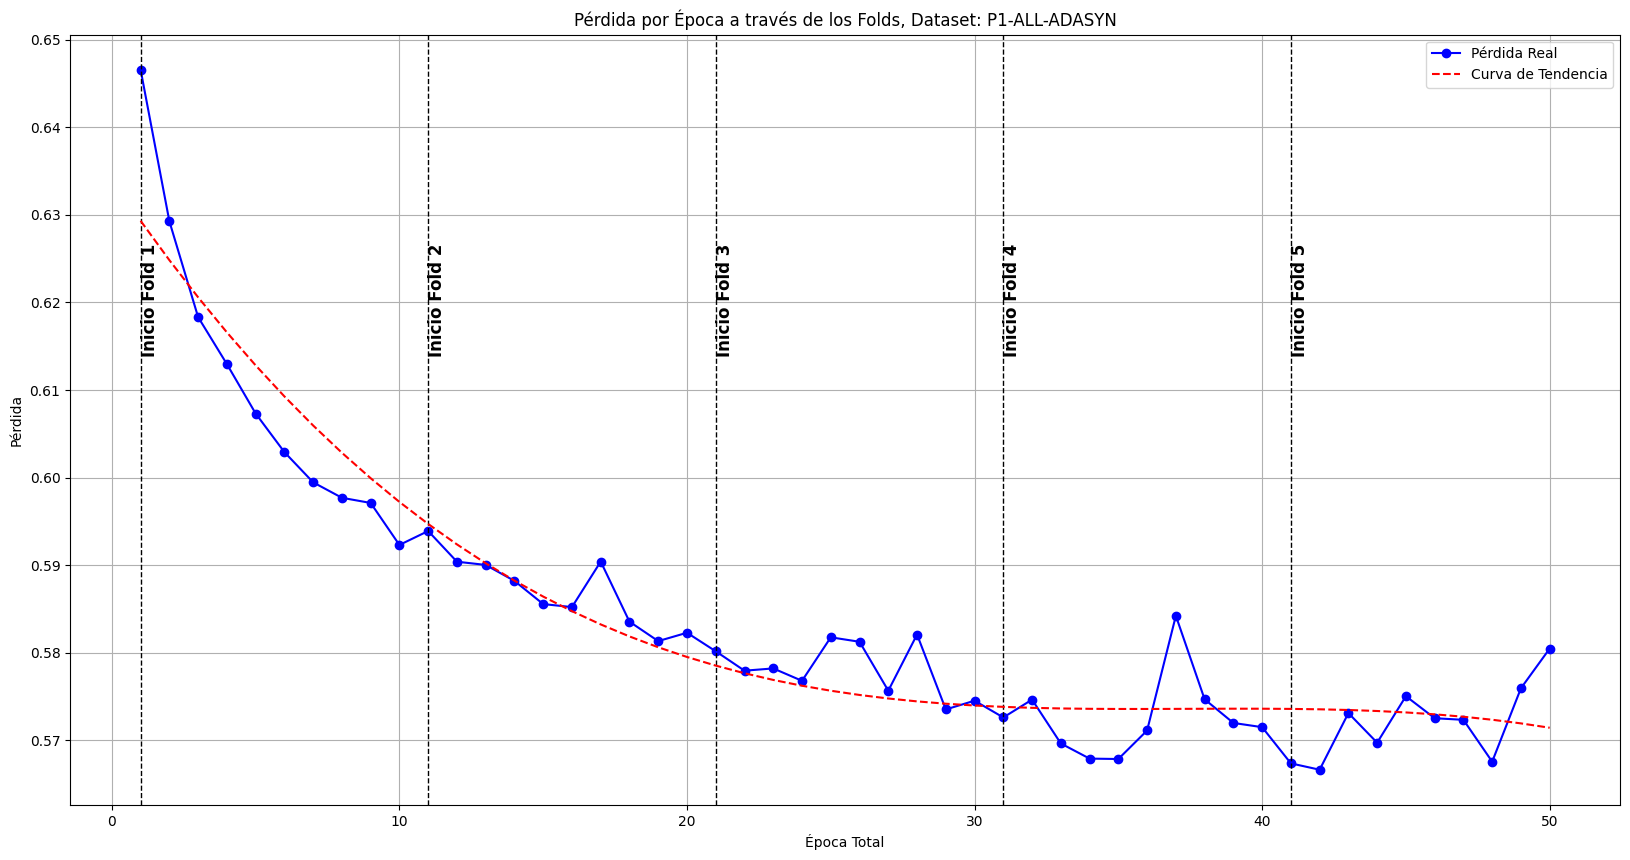

..................................
Resultados datos de entrenamiento:
Accuracy (Datos de Train): 0.7007725645374034
Precision (Datos de Train): 0.6408058663278381
Recall (Datos de Train): 0.8824157411663528
F1 Score (Datos de Train): 0.7424490050527104
[[37183 33358]
 [ 7930 59511]]


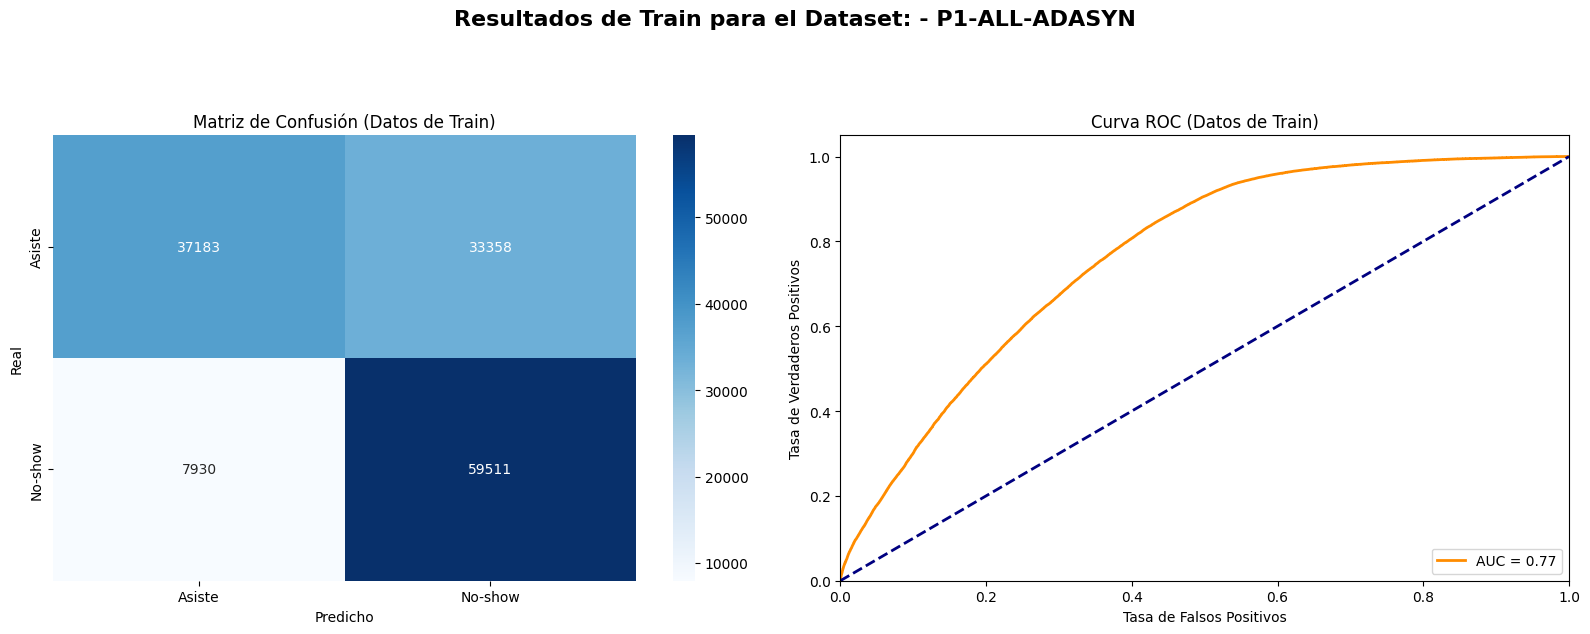

.........................
Resultados datos de test:
Accuracy (Datos de Test): 0.5856903652079468
Precision (Datos de Test): 0.2997098480969449
Recall (Datos de Test): 0.7872674288276171
F1 Score (Datos de Test): 0.43414302490883244
[[9430 8206]
 [ 949 3512]]


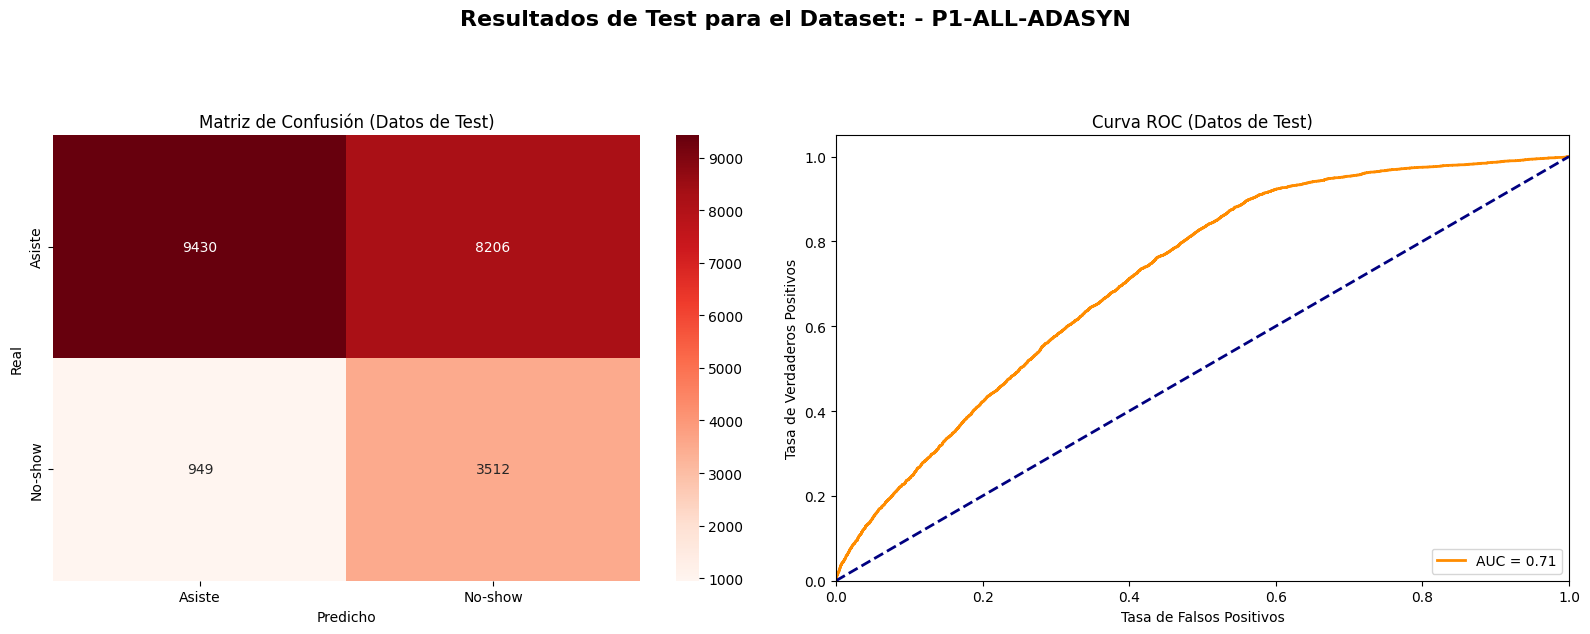


Ejecutando modelo para el dataset: P1-ALL

Comenzando el fold 1
Fold 1, Epoch 1, Train Loss: 0.6522, Val Loss: 0.6187
Fold 1, Epoch 2, Train Loss: 0.6166, Val Loss: 0.5963
Fold 1, Epoch 3, Train Loss: 0.5985, Val Loss: 0.5832
Fold 1, Epoch 4, Train Loss: 0.5900, Val Loss: 0.5762
Fold 1, Epoch 5, Train Loss: 0.5841, Val Loss: 0.5708
Fold 1, Epoch 6, Train Loss: 0.5807, Val Loss: 0.5685
Fold 1, Epoch 7, Train Loss: 0.5768, Val Loss: 0.5646
Fold 1, Epoch 8, Train Loss: 0.5739, Val Loss: 0.5629
Fold 1, Epoch 9, Train Loss: 0.5715, Val Loss: 0.5619
Fold 1, Epoch 10, Train Loss: 0.5686, Val Loss: 0.5572
Comenzando el fold 2
Fold 2, Epoch 1, Train Loss: 0.5680, Val Loss: 0.5605
Fold 2, Epoch 2, Train Loss: 0.5661, Val Loss: 0.5514
Fold 2, Epoch 3, Train Loss: 0.5646, Val Loss: 0.5511
Fold 2, Epoch 4, Train Loss: 0.5620, Val Loss: 0.5516
Fold 2, Epoch 5, Train Loss: 0.5609, Val Loss: 0.5510
Fold 2, Epoch 6, Train Loss: 0.5600, Val Loss: 0.5471
Fold 2, Epoch 7, Train Loss: 0.5583, Val Loss: 0.

KeyboardInterrupt: 

In [5]:
def load_data(file_path):
    return joblib.load(file_path)

# Listado de archivos
X_test_files = [
    "X_test_P1-ALL-ADASYN.pkl", "X_test_P1-ALL.pkl", "X_test_P2-NOCONDITIONS.pkl", 
    "X_test_P3-AGE.pkl", "X_test_P4-TIME.pkl", "X_test_P5-HEALTHCENTRE.pkl"
]

X_train_files = [
    "X_train_P1-ALL-ADASYN.pkl", "X_train_P1-ALL.pkl", "X_train_P2-NOCONDITIONS.pkl", 
    "X_train_P3-AGE.pkl", "X_train_P4-TIME.pkl", "X_train_P5-HEALTHCENTRE.pkl"
]

y_test_files = [
    "y_test_P1-ALL-ADASYN.pkl", "y_test_P1-ALL.pkl", "y_test_P2-NOCONDITIONS.pkl", 
    "y_test_P3-AGE.pkl", "y_test_P4-TIME.pkl", "y_test_P5-HEALTHCENTRE.pkl"
]

y_train_files = [
    "y_train_P1-ALL-ADASYN.pkl", "y_train_P1-ALL.pkl", "y_train_P2-NOCONDITIONS.pkl", 
    "y_train_P3-AGE.pkl", "y_train_P4-TIME.pkl", "y_train_P5-HEALTHCENTRE.pkl"
]

file_names = [
    "P1-ALL-ADASYN", "P1-ALL", "P2-NOCONDITIONS", 
    "P3-AGE", "P4-TIME", "P5-HEALTHCENTRE"
]

# Se cargan los archivos en un diccionario
data = {}
for file_list in [X_test_files, X_train_files, y_test_files, y_train_files]:
    for file_name in file_list:
        data[file_name] = load_data(file_name)

# Se crea bucle para analizar los datos con el modelo de PyTorch
for idx, (X_train_file, y_train_file, X_test_file, y_test_file) in enumerate(zip(X_train_files, y_train_files, X_test_files, y_test_files)):
    try:
        if X_train_file in data and y_train_file in data and X_test_file in data and y_test_file in data:
            X_train = data[X_train_file]
            y_train = data[y_train_file]
            X_test = data[X_test_file]
            y_test = data[y_test_file]

            dataset_name = file_names[idx]
            titulo = f"\n{'='*40}\nEjecutando modelo para el dataset: {dataset_name}\n{'='*40}\n"
            print(titulo)

            execute_model_pytorch(X_train, y_train, X_test, y_test, device='cuda', dataset_name=dataset_name)
        else:
            print(f"Archivos correspondientes no encontrados para {X_train_file}. Omitiendo este archivo.")
    except KeyError as e:
        print(f"Error: {e} - La clave no existe en el diccionario 'data'. Omitiendo este archivo.")
